In [3]:

import os
import sys

import numpy as np
import pandas as pd
import sklearn
from sqlalchemy import create_engine, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import func

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from build_data.models import models, Base as InputsBase



inputs_engine = create_engine('sqlite:///../sql/data.db')
InputsSession = sessionmaker(bind=inputs_engine)
inputs_session = InputsSession()
InputsBase.metadata.create_all(inputs_engine)

query = select(
    models.Variables.date,
    models.Reservoir.level,
    models.Reservoir.streamflow,
    func.sum(models.Variables.precipitation).label('precipitation'),
    func.avg(models.Variables.temperature).label('temperature'),
    func.sum(models.Variables.evaporation).label('evaporation'),
    func.avg(models.Variables.surface_runoff).label('surface_runoff'),
    models.Coordinate.river_id.label('river')
).\
    join(models.Variables.coordinate).\
    join(models.Reservoir, models.Variables.date == models.Reservoir.date).\
    group_by(models.Variables.date).\
    group_by(models.Coordinate.river_id)


In [4]:
df = pd.read_sql(query, inputs_session.bind)

df

,date,level,streamflow,precipitation,temperature,evaporation,surface_runoff,river
0,1999-01-01,560.19,854.00,671.024707,27.368151,393.536845,4.099641e-01,1
1,1999-01-01,560.19,854.00,465.102216,26.788190,450.157972,2.201662e-01,2
2,1999-01-01,560.19,854.00,66.869122,27.946012,59.962737,1.538050e-01,3
3,1999-01-01,560.19,854.00,52.767011,27.666216,48.419736,1.331286e-01,4
4,1999-01-01,560.19,854.00,123.202071,27.475916,120.222209,1.135617e-01,5
...,...,...,...,...,...,...,...,...
27583,2005-12-30,568.35,881.33,0.000000,26.716494,112.834370,0.000000e+00,7
27584,2005-12-30,568.35,881.33,0.000000,26.095913,212.261747,1.160423e-10,8
27585,2005-12-30,568.35,881.33,1503.795052,24.308467,1937.032651,7.842172e-02,9
27586,2005-12-30,568.35,881.33,4849.088002,23.603858,3396.991142,2.253774e-01,10


In [5]:
normalized_df = df.copy()
normalized_df = (df - df.min()) / (df.max() - df.min())
normalized_df['date'] = df['date'] # forma mais direta de não normalizar as datas
normalized_df['river'] = df['river'] # forma mais direta de não normalizar os rios
normalized_df

,date,level,streamflow,precipitation,temperature,evaporation,surface_runoff,river
0,1999-01-01,0.397174,0.194431,0.013186,0.732535,0.061318,0.038152,1
1,1999-01-01,0.397174,0.194431,0.009139,0.707612,0.070229,0.020489,2
2,1999-01-01,0.397174,0.194431,0.001314,0.757368,0.008819,0.014313,3
3,1999-01-01,0.397174,0.194431,0.001037,0.745344,0.007003,0.012389,4
4,1999-01-01,0.397174,0.194431,0.002421,0.737166,0.018303,0.010568,5
...,...,...,...,...,...,...,...,...
27583,2005-12-30,0.824176,0.200652,0.0,0.704531,0.017141,0.0,7
27584,2005-12-30,0.824176,0.200652,0.0,0.677863,0.032789,0.0,8
27585,2005-12-30,0.824176,0.200652,0.02955,0.601051,0.304238,0.007298,9
27586,2005-12-30,0.824176,0.200652,0.095287,0.570771,0.53401,0.020974,10


In [6]:
pivoted_df = normalized_df.pivot(index=["date", "level", "streamflow"], columns="river")

pivoted_df

precipitation                                \
river                                     1         2         3         4    
date       level    streamflow                                               
1999-01-01 0.397174 0.194431        0.013186  0.009139  0.001314  0.001037   
1999-01-02 0.401884 0.256801        0.015597  0.009623  0.002175  0.001682   
1999-01-03 0.405547 0.232445        0.021591  0.021098   0.00377  0.002668   
1999-01-04 0.411826 0.297546        0.018986   0.01819  0.002194  0.001728   
1999-01-05 0.419676 0.337153        0.005367   0.00706  0.000055  0.000146   
...                                      ...       ...       ...       ...   
2005-12-26 0.832548 0.243168        0.001222  0.005355  0.000003  0.000014   
2005-12-27 0.828885 0.233911        0.002752  0.002645  0.000566   0.00052   
2005-12-28 0.826792 0.205578        0.013428  0.024917  0.001576  0.001092   
2005-12-29 0.825746 0.251921        0.031226  0.040078  0.005319  0.004017   
2005-12-30 0.824176 0.200652        0.000365  0.000784       0.0       0.0   

                                                                        \
river                                 5         6         7         8    
date       level    streamflow                                           
1999-01-01 0.397174 0.194431    0.002421  0.002176  0.005779  0.008753   
1999-01-02 0.401884 0.256801    0.004179  0.003078  0.008686  0.013997   
1999-01-03 0.405547 0.232445    0.005921  0.004294  0.005834  0.012385   
1999-01-04 0.411826 0.297546    0.004308    0.0036  0.002635  0.004703   
1999-01-05 0.419676 0.337153    0.000536  0.000428  0.003022  0.003549   
...                                  ...       ...       ...       ...   
2005-12-26 0.832548 0.243168    0.000098  0.000526       0.0       0.0   
2005-12-27 0.828885 0.233911    0.001318  0.001094  0.001222   0.00236   
2005-12-28 0.826792 0.205578    0.002733  0.002682  0.002504  0.005894   
2005-12-29 0.825746 0.251921    0.009856  0.008149  0.010256  0.019276   
2005-12-30 0.824176 0.200652         0.0       0.0       0.0       0.0   

                                                    ... surface_runoff  \
river                                 9         10  ...             2    
date       level    streamflow                      ...                  
1999-01-01 0.397174 0.194431    0.118041  0.137345  ...       0.020489   
1999-01-02 0.401884 0.256801    0.135584  0.173141  ...       0.023038   
1999-01-03 0.405547 0.232445    0.131361  0.267749  ...       0.042976   
1999-01-04 0.411826 0.297546     0.07621  0.323723  ...       0.041822   
1999-01-05 0.419676 0.337153    0.042908  0.088838  ...       0.008056   
...                                  ...       ...  ...            ...   
2005-12-26 0.832548 0.243168    0.006934  0.145241  ...       0.012314   
2005-12-27 0.828885 0.233911    0.057391   0.16875  ...       0.000297   
2005-12-28 0.826792 0.205578    0.087414  0.487792  ...       0.039267   
2005-12-29 0.825746 0.251921    0.135268  0.374594  ...       0.088872   
2005-12-30 0.824176 0.200652     0.02955  0.095287  ...       0.000235   

                                                                        \
river                                 3         4         5         6    
date       level    streamflow                                           
1999-01-01 0.397174 0.194431    0.014313  0.012389  0.010568  0.010641   
1999-01-02 0.401884 0.256801    0.038627  0.039164  0.036809  0.023524   
1999-01-03 0.405547 0.232445    0.053009  0.046228  0.040515  0.030415   
1999-01-04 0.411826 0.297546    0.022712  0.023116  0.022753  0.020577   
1999-01-05 0.419676 0.337153    0.000109  0.000377  0.000544  0.000467   
...                                  ...       ...       ...       ...   
2005-12-26 0.832548 0.243168    0.000001  0.000021  0.000551   0.00382   
2005-12-27 0.828885 0.233911    0.000659  0.000683  0.000663  0.001115   
2005-12-28 0.826792 0.205578    0.008032  0.007853

In [7]:
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(pivoted_df, pivoted_df.index.get_level_values('level'), test_size=0.3)
X_train2, X_test2, y_train2, y_test2 = train_test_split(pivoted_df, pivoted_df.index.get_level_values('streamflow'), test_size=0.3)

In [8]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
#from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_absolute_percentage_error

#explained_variance_score(y_pred, y_test, multioutput='raw_values')
#max_error(y_pred, y_test)
#mean_absolute_error(y_pred, y_test)
#mean_squared_error(y_pred, y_test)
#mean_squared_log_error(y_pred, y_test)
#mean_absolute_percentage_error(y_pred, y_test)

In [9]:
results = np.zeros(1000)
results2 = np.zeros(1000)
j = 0

for i in np.arange(0.1, 33, 0.5):
    regr = svm.SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=i, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    temp = mean_squared_error(y_pred, y_test)
    results[j]= temp

    regr = svm.SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=i, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
    regr.fit(X_train2, y_train2)
    y_pred2 = regr.predict(X_test2)
    temp2 = mean_squared_error(y_pred2, y_test2)
    results2[j]= temp2
    
    j = j+1

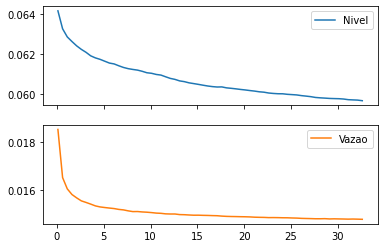

In [10]:
results = results[results != 0]
results2 = results2[results2 != 0]

df = pd.DataFrame({'Nivel': results, 'Vazao': results2}, 
                  index=np.arange(0.1, 33, 0.5))
lines = df.plot.line(subplots=True)


In [11]:
from sklearn.ensemble import RandomForestRegressor

results3 = np.zeros(1000)
results4 = np.zeros(1000)
j = 0

for i in np.arange(1, 100, 5):
    regr = RandomForestRegressor(max_depth=i, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    temp = mean_squared_error(y_pred, y_test2)
    results3[j]= temp
    
    regr = RandomForestRegressor(max_depth=i, random_state=0)
    regr.fit(X_train2, y_train2)
    y_pred2 = regr.predict(X_test)

    temp2 = mean_squared_error(y_pred2, y_test2)
    results4[j]= temp2
    
    j = j+1

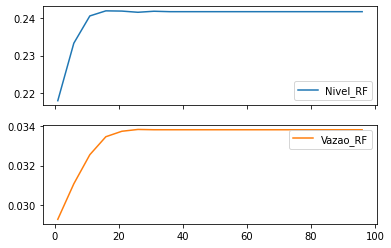

In [12]:
results3 = results3[results3 != 0]
results4 = results4[results4 != 0]

results3

df = pd.DataFrame({'Nivel_RF': results3, 'Vazao_RF': results4}, 
                  index=np.arange(1, 100, 5))
lines = df.plot.line(subplots=True)